# Mappers
Deeper analysis 

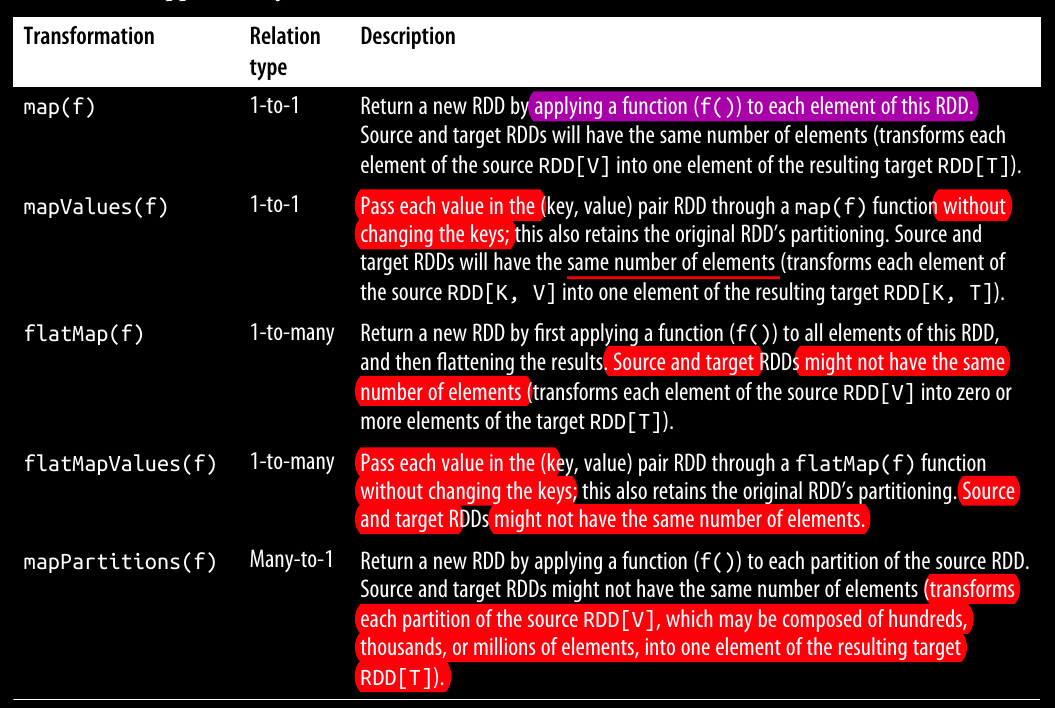



> so basically **map** applied the func() to both, to key and value, whereas **mapValues** only applied the function to the values 

In [2]:
from pyspark.sql import SparkSession
# Create an instance of SparkSession
spark = SparkSession.builder.getOrCreate()
#spark = SparkSession.builder.appName("ch01").getOrCreate()

24/05/17 11:53:33 WARN Utils: Your hostname, msi-MAG resolves to a loopback address: 127.0.1.1; using 192.168.0.129 instead (on interface wlp3s0)
24/05/17 11:53:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/17 11:53:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Map()
* This is a 1-to-1 transformation (from N elements to N elements) 
* acts above key and value (<mark>BETTER: you use it when there is no key and value, like a list</mark>)
* Is not sequential
    * Your source RDD is partitioned into P partitions, which are then processed independently and concurrently. 

> if your source RDD has 40 billion elements and P = 20,000, then each partition will
have roughly 2 million elements (40 billion = 20,000 x 2 million). 

# RDD mappers

In [3]:
data = [1, -1, -2, 3, 4]
rdd = spark.sparkContext.parallelize(data)
rdd.collect()

[1, -1, -2, 3, 4]

In [4]:
def mapper_func(x):
    if (x > 0):
        return x+5
    else:
        return 0

In [8]:
# Form 1: pass the function directly
rdd.map(mapper_func).collect()

[6, 0, 0, 8, 9]

In [10]:
#form 2: use lambda
rdd.map(lambda x : mapper_func(x)).collect()

[6, 0, 0, 8, 9]

In [11]:
# a twist: more elements
rdd4 = rdd.map(lambda x : (x, mapper_func(x)))
rdd4.collect()

[(1, 6), (-1, 0), (-2, 0), (3, 8), (4, 9)]

In [16]:
# adding an index
rdd1 = rdd.zipWithIndex()
rdd1.collect()

[(1, 0), (-1, 1), (-2, 2), (3, 3), (4, 4)]

In [17]:
# invert the order and apply Transofmation
rdd1.map(lambda x: (x[1],mapper_func(x[0]))).collect()

[(0, 6), (1, 0), (2, 0), (3, 8), (4, 9)]

In [19]:
# the same but using MapValues for the transform 
# 1 - swap the values (index is at ix-1)
# 2 - apply the funct to the values only
rdd1.map(lambda x: (x[1],x[0])).mapValues(mapper_func).collect()

[(0, 6), (1, 0), (2, 0), (3, 8), (4, 9)]

another example

In [20]:
pairs = [('a', 2), ('b', -1), ('d', -2), ('e', 3)]
rdd = spark.sparkContext.parallelize(pairs)
rdd.collect()


[('a', 2), ('b', -1), ('d', -2), ('e', 3)]

In [23]:
rdd.map(lambda x: (x[0]+'a', x[1], x[1]+100)).collect()


[('aa', 2, 102), ('ba', -1, 99), ('da', -2, 98), ('ea', 3, 103)]

In [24]:
def create_key_value(string):
    tokens = string.split(",")
    return (tokens[0], (tokens[1], tokens[2]))

strings = ['a,10,11', 'b,8,19', 'c,20,21', 'c,2,8']
rdd = spark.sparkContext.parallelize(strings)
rdd.map(create_key_value).collect()

[('a', ('10', '11')),
 ('b', ('8', '19')),
 ('c', ('20', '21')),
 ('c', ('2', '8'))]

# DataFrame Mapper
Spark’s DataFrame does not have a map() function, use SQL

In [25]:
tuples3 = [ ('alex', 440, 'PHD'), ('jane', 420, 'PHD'),
('bob', 280, 'MS'), ('betty', 200, 'MS'),
('ted', 180, 'BS'), ('mary', 100, 'BS') ]

In [26]:
df = spark.createDataFrame(tuples3, ["name", "amount", "education"])
df.show()

+-----+------+---------+
| name|amount|education|
+-----+------+---------+
| alex|   440|      PHD|
| jane|   420|      PHD|
|  bob|   280|       MS|
|betty|   200|       MS|
|  ted|   180|       BS|
| mary|   100|       BS|
+-----+------+---------+



In [27]:
import pyspark.sql.functions as F

the '**dataframe-way**' <br> 
Seems that RDD are of no use this days

In [29]:
df.withColumn("bonus", F.col("amount")/10).show()

+-----+------+---------+-----+
| name|amount|education|bonus|
+-----+------+---------+-----+
| alex|   440|      PHD| 44.0|
| jane|   420|      PHD| 42.0|
|  bob|   280|       MS| 28.0|
|betty|   200|       MS| 20.0|
|  ted|   180|       BS| 18.0|
| mary|   100|       BS| 10.0|
+-----+------+---------+-----+



#### Mapper to multiple DataFrame columns
Now, assume that you want to add a bonus column, which depends on two columns:
“amount” and “education”: The bonus column is calculated as:
* bonus = amount * 30% if education = PHD
* bonus = amount * 20% if education = MS
* bonus = amount * 10% all other cases

> **The UDF way** <br>
> user-defined function (UDF): define a Python function and then register it as a UDF:

In [30]:
def compute_bonus(amount, education):
    if education == "PHD": return int(amount * 0.30)
    if education == "MS": return int(amount * 0.20)
    return int(amount * 0.10)


In [31]:
from pyspark.sql.functions import udf

In [33]:
from pyspark.sql.types import IntegerType

register `compute_bonus` as a udf

In [34]:
compute_bonus_udf = udf(lambda amount, education: compute_bonus(amount, education), IntegerType())

In [35]:
df.withColumn('bonus', compute_bonus_udf(df['amount'], df['education'])).show()

+-----+------+---------+-----+
| name|amount|education|bonus|
+-----+------+---------+-----+
| alex|   440|      PHD|  132|
| jane|   420|      PHD|  126|
|  bob|   280|       MS|   56|
|betty|   200|       MS|   40|
|  ted|   180|       BS|   18|
| mary|   100|       BS|   10|
+-----+------+---------+-----+



rdd.collect()

# FlatMap() DataFrame
> from now and on I will only conentrate on DataFrames


> DataFrame has the function pyspark.sql.functions.explode(col), which is used to flatten the column. The explode(column) returns a new row for each element in the given column
(expressed as a list or dictionary) and uses the default column name col for elements.
Empty elements are droped

In [36]:
some_data = [
    ('alex', ['Java','Scala', 'Python']),
    ('jane', ['Cobol','Snobol']),
    ('bob',['C++',]),
    ('ted', []),
    ('max', [])
]

In [38]:
df = spark.createDataFrame(data=some_data, schema = ['name', 'known_languages'])
df.show(truncate=False)

+----+---------------------+
|name|known_languages      |
+----+---------------------+
|alex|[Java, Scala, Python]|
|jane|[Cobol, Snobol]      |
|bob |[C++]                |
|ted |[]                   |
|max |[]                   |
+----+---------------------+



In [40]:
df.select(df.name, F.explode(df.known_languages).alias('language')).show()
# ted and max are dropped because NULL

+----+--------+
|name|language|
+----+--------+
|alex|    Java|
|alex|   Scala|
|alex|  Python|
|jane|   Cobol|
|jane|  Snobol|
| bob|     C++|
+----+--------+



Next, we’ll look at exploding multiple columns for a given DataFrame. Note that only
one generator is allowed per select clause: this means you can not explode two col‐
umns at the same time (but you can explode them iteratively one-by-one).

In [41]:
some_data = [
 ('alex', ['Java','Scala', 'Python'], ['MS', 'PHD']),
 ('jane', ['Cobol','Snobol'], ['BS', 'MS']),
 ('bob', ['C++'], ['BS', 'MS', 'PHD']),
 ('ted', [], ['BS', 'MS']),
 ('max', ['FORTRAN'], []),
 ('dan', [], []) 
]

In [44]:
df = spark.createDataFrame(data=some_data, schema=['name','language', 'education'])
df.show()

+----+--------------------+-------------+
|name|            language|    education|
+----+--------------------+-------------+
|alex|[Java, Scala, Pyt...|    [MS, PHD]|
|jane|     [Cobol, Snobol]|     [BS, MS]|
| bob|               [C++]|[BS, MS, PHD]|
| ted|                  []|     [BS, MS]|
| max|           [FORTRAN]|           []|
| dan|                  []|           []|
+----+--------------------+-------------+



allowed one-by-one

In [48]:
df.select(df.name, F.explode(df.language).alias('language'), df.education).show()

+----+--------+-------------+
|name|language|    education|
+----+--------+-------------+
|alex|    Java|    [MS, PHD]|
|alex|   Scala|    [MS, PHD]|
|alex|  Python|    [MS, PHD]|
|jane|   Cobol|     [BS, MS]|
|jane|  Snobol|     [BS, MS]|
| bob|     C++|[BS, MS, PHD]|
| max| FORTRAN|           []|
+----+--------+-------------+



with 2 columns - using direct "" col sintax

In [53]:
df.select(
     "name",
    F.explode(df.language).alias('language'),
    "education"
).select(
    "name",
    "language",
    F.explode(df.education).alias('education')
).show()

+----+--------+---------+
|name|language|education|
+----+--------+---------+
|alex|    Java|       MS|
|alex|    Java|      PHD|
|alex|   Scala|       MS|
|alex|   Scala|      PHD|
|alex|  Python|       MS|
|alex|  Python|      PHD|
|jane|   Cobol|       BS|
|jane|   Cobol|       MS|
|jane|  Snobol|       BS|
|jane|  Snobol|       MS|
| bob|     C++|       BS|
| bob|     C++|       MS|
| bob|     C++|      PHD|
+----+--------+---------+



# DataFrames and mapPartitions() Transformation
DF don't have an equivalent, because they dont need it, Given a DataFrame, you can easily summarize your data with a SQL transformation

In [54]:
tuples3 = [
('clothing', 'shirt', 20), ('clothing', 'tshirt', 10), ('clothing', 'pants', 30),
('fruit', 'banana', 3), ('fruit', 'apple', 4), ('fruit', 'orange', 5),
('veggie', 'carrot', 7), ('veggie', 'tomato', 8), ('veggie', 'potato', 9)
]

In [55]:
df = spark.createDataFrame(tuples3, ["group_id", "item", "price"])
df.show(truncate=False)

+--------+------+-----+
|group_id|item  |price|
+--------+------+-----+
|clothing|shirt |20   |
|clothing|tshirt|10   |
|clothing|pants |30   |
|fruit   |banana|3    |
|fruit   |apple |4    |
|fruit   |orange|5    |
|veggie  |carrot|7    |
|veggie  |tomato|8    |
|veggie  |potato|9    |
+--------+------+-----+



In [56]:
df.groupby('group_id').agg({'price': 'min'}).show()

+--------+----------+
|group_id|min(price)|
+--------+----------+
|clothing|        10|
|   fruit|         3|
|  veggie|         7|
+--------+----------+



In [58]:
df.groupby('group_id').agg({'price': 'max'}).show()

+--------+----------+
|group_id|max(price)|
+--------+----------+
|clothing|        30|
|   fruit|         5|
|  veggie|         9|
+--------+----------+



A dictionary in Python cannot have duplicate keys. In your case, you're trying to specify two aggregations ('min' and 'max') for the same column 'price', but since dictionaries can't have duplicate keys, **only one of the aggregations will be considered.**

In [59]:
# two at the same time

# SOL 1
df.groupby('group_id').agg(
    F.min('price').alias('min_price'),
    F.max('price').alias('max_price')
).show() 


+--------+---------+---------+
|group_id|min_price|max_price|
+--------+---------+---------+
|clothing|       10|       30|
|   fruit|        3|        5|
|  veggie|        7|        9|
+--------+---------+---------+



Using SparkSQL

In [60]:
# Create a temporary view
df.createOrReplaceTempView("sales")

In [61]:
spark.sql("""
    SELECT group_id, 
           MIN(price) AS min_price, 
           MAX(price) AS max_price 
    FROM sales 
    GROUP BY group_id
""").show()

+--------+---------+---------+
|group_id|min_price|max_price|
+--------+---------+---------+
|clothing|       10|       30|
|   fruit|        3|        5|
|  veggie|        7|        9|
+--------+---------+---------+

